In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from data_analysis.helpers import *

In [36]:
def plotter(
    param_list,
    filters,
    label,
    draw_style,
    test_config,
    topology,
    db,
    metric,
    ax,
    x_variant,
):
    param_list = filterParamList(param_list, filters)
    res = getDataFieldSumAvgsAcrossSeeds(
        topology,
        db,
        param_list,
        test_config["source_map_seed"],
        test_config["request_generator_seed"],
        metric,
    )
    ax.plot(list(map(str, x_variant)), res, draw_style, fillstyle='none', label=label)


def plotLooper(
    test_config,
    db,
    case_filters,
    ax,
    experiment_name,
    x_label,
    metric,
    topology,
    cache_pols=None,
    curve_label=None,
):
    param_list = simConfigToParamSets(test_config)
    param_list = filterParamList(param_list, case_filters)
    
    x_variant = test_config[x_label]
    if isinstance(x_variant[0], list):
        x_variant = list(map(tuple, x_variant))

    if curve_label:
        curve_variant = test_config[curve_label]
        if isinstance(curve_variant[0], list):
            curve_variant = list(map(tuple, curve_variant))
    else:
        curve_variant = []

    legend = []

    line_styles = {'vip2': 'bv', 'mvip': 'r^', 'lfu': 'ks', 'lru': 'gx', 'fifo': 'md', 'unif': 'yo'}
    dashes = ['-','--',':']
    
    if cache_pols is None:
        cache_pols = [pol for pol in test_config["cache_pol"]]

    for cache_pol in cache_pols:
        filters = [("cache_pol", cache_pol, None)]
        if curve_variant:
            filters.append(())
            for i, curve in enumerate(curve_variant):
                label = cache_pol + ", " + curve_label + " " + str(curve)
                legend.append(label)
                filters[1] = (curve_label, curve, None)
                plotter(
                    param_list=param_list,
                    filters=filters,
                    label=label,
                    draw_style=dashes[i]+line_styles[cache_pol],
                    test_config=test_config,
                    topology=topology,
                    db=db,
                    metric=metric,
                    ax=ax,
                    x_variant=x_variant,
                )
        else:
            label = cache_pol
            legend.append(label)
            plotter(
                param_list=param_list,
                filters=filters,
                label=label,
                draw_style='-'+line_styles[cache_pol],
                test_config=test_config,
                topology=topology,
                db=db,
                metric=metric,
                ax=ax,
                x_variant=x_variant,
            )

    ax.set_title(experiment_name + " on " + topology)
    ax.set_xlabel(x_label)
    ax.set_ylabel(metric)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
    ax.legend(legend)

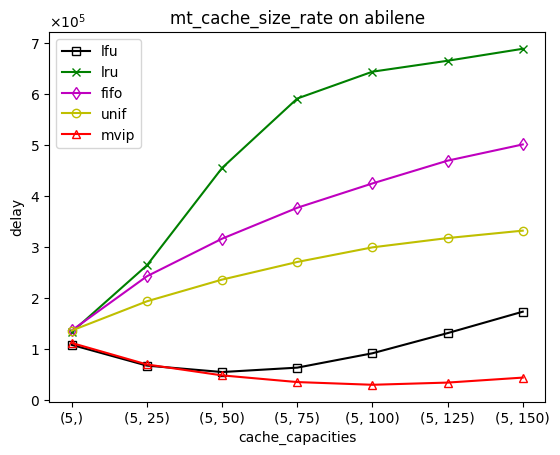

In [39]:
experiment_name = "mt_cache_size_rate"
topology = "abilene"
config_path = "../sim_configs/" + experiment_name + "_config.json"
test_config = getTestConfig(config_path)
db_path = "../sim_outputs/" + experiment_name + "_" + topology + "_db.json"
db = getJsonDb(db_path)

case_filters = [
    ("cache_read_rates", [(25,), (25, 10)], None),
    ("request_dist_param", 0.5, None),
]

fig, ax = plt.subplots()
plotLooper(
    test_config=test_config,
    db=db,
    case_filters=case_filters,
    ax=ax,
    experiment_name=experiment_name,
    x_label="cache_capacities",
    metric="delay",
    topology=topology,
)

plt.show()